In [63]:
using JuMP, Gurobi, Ipopt,AmplNLWriter, NLopt
using Mosek, Cbc
    k = 3              # number of waypoints
    ko = 2             # number of obstacles
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations
    xo = zeros(2,ko)   # vector of obstacle locations
    bbo = zeros(2,ko)  # bounding box around obstacle
    
    A = [1 0;
        -1 0;
        0 1;
        0 -1;]
    bo = zeros(4,ko)
    
    T[1] = 1
    T[2] = 20
    T[3] = 40

    # define waypoints
    xw = [ 0.5   4  -6
           1.5   3  6]
    
    xo = [ 2 0
           2 4 ]
    
    bbo = [ 0.5 0.5
            1.0 0.5]

    for i in 1:ko
        bo[1,i] = xo[1,i] - bbo[1,i]
        bo[2,i] = -(xo[1,i] + bbo[1,i])
        bo[3,i] = xo[2,i] - bbo[2,i]
        bo[4,i] = -(xo[2,i] + bbo[2,i])
    end;

In [81]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, x[1:2,1:T[k]])  # resulting position
    @variable(m, v[1:2,1:T[k]])  # resulting velocity
    @variable(m, u[1:2,1:T[k]])  # thruster input
    @variable(m, obstacle[1:ko,1:4,1:T[k]], Bin)
    vMax = 0.5
    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0])

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    # Avoid all obstacles
    for o in 1:ko
        for t in 1:T[k]-1
            @constraint(m, A*x[:,t] .<= bo[:,o] .+ 1000*obstacle[o,:,t])
            @constraint(m, sum(obstacle[o,i,t] for i in 1:4) <= 3)
        end
    end
    
    # hit all the waypoints
    for t in [1 k]
        @constraint(m, x[:,T[t]] .== xw[:,t])
    end

    for t in 1:T[k]
        @constraint(m, sum(v[:,t].^2) <= vMax)
    end
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100/1
    β = 100/100
    @objective(m, Min, sum(u.^2) + λ*sum((x[:,T[2:k]]-xw[:,2:k]).^2) + β*sum((sum((v[:,t] .- vMax).^2 for t in 2:T[k]))))
    solve(m)
    xopt=getvalue(x)

2×40 Array{Float64,2}:
 0.5  0.5  0.5576   0.63722  0.725299  …  -4.64999  -5.19262  -5.67508  -6.0
 1.5  1.5  1.59372  1.72322  1.86639       5.22631   5.46059   5.71022   6.0

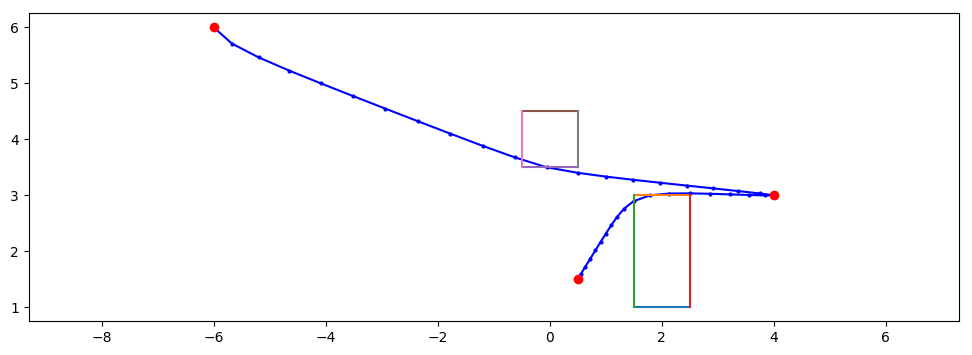

In [82]:
using PyPlot
figure(figsize=(12,4))
plot( xopt[1,:][:], xopt[2,:][:], "b.-", markersize=4 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )

for o in 1:ko
    # lower and upper lines
    plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
        0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] - bbo[2,o]))
    plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
        0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] + bbo[2,o]))

    # left and right lines
    plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] - bbo[1,o]),
        linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
    plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] + bbo[1,o]),
        linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
end
axis("equal");

In [78]:
getobjectivevalue(m)

2.984303037742251

In [67]:
xopt = (getvalue(x))

2×40 Array{Float64,2}:
 0.5  0.5  0.592265  0.719899  …  -4.77239  -5.27025  -5.71051  -6.0
 1.5  1.5  1.63411   1.81935       5.28017   5.49476   5.72581   6.0

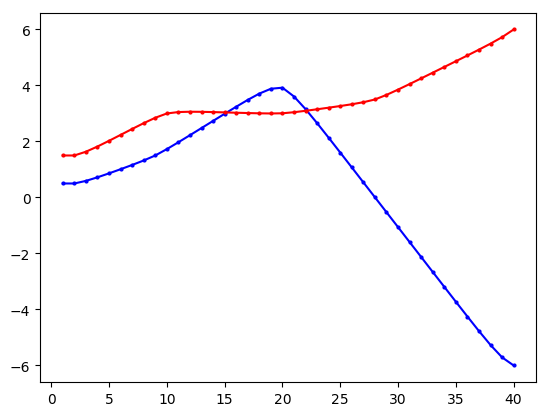

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32763cf50>

In [68]:
plot( linspace(1,40,40), xopt[1,:], "b.-", markersize=4 )
plot( linspace(1,40,40), xopt[2,:], "r.-", markersize=4 )

In [69]:
vopt = getvalue(v)

2×40 Array{Float64,2}:
 -0.0  0.0922649  0.127634  0.141478  …  -0.440266  -0.289488  0.105256
 -0.0  0.134113   0.185235  0.204489      0.231058   0.274186  0.387093

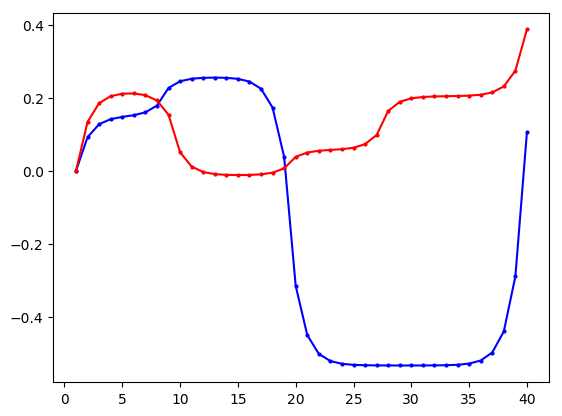

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326d1f110>

In [70]:
plot( linspace(1,40,40), vopt[1,:], "b.-", markersize=4 )
plot( linspace(1,40,40), vopt[2,:], "r.-", markersize=4 )